Train a deep learning model to classify beetles, cockroaches and dragonflies using these images. Note: Original images from https://www.insectimages.org/index.cfm. Blog about this, and explain how the neural network classified the images.

### Prepare Data

In [1]:
import zipfile
with zipfile.ZipFile('insects.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

from sklearn.preprocessing import LabelEncoder

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable

import warnings
warnings.simplefilter('ignore', FutureWarning)

In [3]:
def image_read_in(directory, check_directory = None):
    ''' 
    Read in original images with check for duplication and empty. Transform into array. 
    '''
    
    img_ = []
    for file in os.listdir(directory):
        
        # check for duplicate
        if check_directory is not None and file in os.listdir(check_directory):
            continue
            
        img = cv2.imread(directory + '/' + file)
        if img is not None:
            img = cv2.resize(img, dsize=(84, 84), interpolation=cv2.INTER_CUBIC)
            img_.append(img)
            
    return img_

def save_by_type(cat, code, train_path, test_path):
    '''
    Read in and save images by type. Label each type by a numerical code.
    '''
    
    directory1 = train_path + cat
    directory2 = test_path + cat
    
    # training
    X_cat_train = image_read_in(directory1, directory2)
    y_cat_train = np.repeat(code, len(X_cat_train))
    
    # testing 
    X_cat_test = image_read_in(directory2)
    y_cat_test = np.repeat(code, len(X_cat_test))
    
    return X_cat_train, X_cat_test, y_cat_train, y_cat_test

In [4]:
# read in train and test by type

# Labels: 'beetles' - 0; 'cockroach', 1; 'dragonflies', 2

X_beetles_train, X_beetles_test, y_beetles_train, y_beetles_test = save_by_type(
    'beetles', 0, 'insects/train/', 'insects/test/')

X_cock_train, X_cock_test, y_cock_train, y_cock_test = save_by_type(
    'cockroach', 1, 'insects/train/', 'insects/test/')

X_dragon_train, X_dragon_test, y_dragon_train, y_dragon_test = save_by_type(
    'dragonflies', 2, 'insects/train/', 'insects/test/')

In [5]:
print(X_beetles_train[0].shape, len(X_beetles_train))
print(X_cock_train[0].shape, len(X_cock_train))
print(X_dragon_train[0].shape, len(X_dragon_train))

print(X_beetles_test[0].shape, len(X_beetles_test))
print(X_cock_test[0].shape, len(X_cock_test))
print(X_dragon_test[0].shape, len(X_dragon_test))

(84, 84, 3) 400
(84, 84, 3) 180
(84, 84, 3) 259
(84, 84, 3) 60
(84, 84, 3) 60
(84, 84, 3) 60


In [6]:
# the overall sets
X_train = list(X_beetles_train) + list(X_cock_train) + list(X_dragon_train)
X_test = list(X_beetles_test) + list(X_cock_test) + list(X_dragon_test)
y_train = list(y_beetles_train) + list(y_cock_train) + list(y_dragon_train)
y_test = list(y_beetles_test) + list(y_cock_test) + list(y_dragon_test)

In [7]:
len(X_train), len(y_train), len(X_test), len(y_test)

(839, 839, 180, 180)

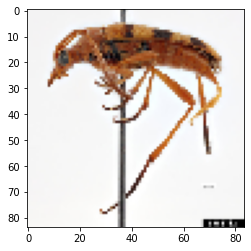

In [8]:
plt.imshow(X_test[0][:,:,::-1])
plt.show()

### CNN

The LeNet architecture was first introduced by LeCun et al. in their 1998 paper, [Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). As the name of the paper suggests, the authors’ implementation of LeNet was used primarily for OCR and character recognition in documents.

The LeNet architecture is straightforward and small, (in terms of memory footprint), making it perfect for teaching the basics of CNNs — it can even run on the CPU (if your system does not have a suitable GPU), making it a great “first CNN”.

However, if you do have GPU support, you will enjoy extremely fast training times (in the order of 3-10 seconds per epoch, depending on your GPU).

_____

[LeNet](http://yann.lecun.com/exdb/lenet/) is a classic CNN architecture for MNIST dataset proposed in 1990’s 

![LeNet5](https://miro.medium.com/max/2154/1*1TI1aGBZ4dybR6__DI9dzA.png)

In [9]:
batch_size = 32

# pytorch preprocessing
X_train_ = torch.Tensor(np.array(X_train) / 255) # the pixels falling in the range [0, 255], Normalize value to [0, 1]
X_test_ = torch.Tensor(np.array(X_test) / 255)
y_train_ = torch.Tensor(y_train).long()
y_test_ = torch.Tensor(y_test).long()

train_set = torch.utils.data.TensorDataset(X_train_, y_train_)
test_set = torch.utils.data.TensorDataset(X_test_, y_test_)

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

In [10]:
class LeNet5(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, stride=2, padding=1, bias=True) # in=3
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=0, bias=True)
        self.fc1   = nn.Linear(in_features=64 * 9 * 9, out_features=256) 
        self.fc2   = nn.Linear(in_features=256, out_features=84) # attempted kernel 32, 64, 128, 256
        self.fc3   = nn.Linear(in_features=84, out_features=out_channels) # out=3

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    '''
    Function for training.
    '''
    
    train_loss = 0
    correct = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = Variable(data.reshape(-1, 3, 84, 84))
        target = Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        if batch_idx % (len(train_loader)//2) == 0:
            print('Train({})[{:.0f}%]: Loss: {:.4f}'.format(
                epoch, 100. * batch_idx / len(train_loader), train_loss/(batch_idx+1)))
    acc = correct / len(train_loader.dataset)
    
    return acc

def test(model, device, test_loader, criterion, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = Variable(data.reshape(-1, 3, 84, 84))
            target = Variable(target)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = (test_loss*batch_size)/len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)
    print('Test({}): Loss: {:.4f}, Accuracy: {:.4f}%'.format(
        epoch, test_loss, 100. * correct / len(test_loader.dataset)))
    
    return acc

In [12]:
def make_optimizer(optimizer_name, model, **kwargs):
    if optimizer_name=='Adam':
        optimizer = optim.Adam(model.parameters(),lr=kwargs['lr'])
    elif optimizer_name=='SGD':
        optimizer = optim.SGD(model.parameters(),lr=kwargs['lr'],momentum=kwargs['momentum'], weight_decay=kwargs['weight_decay'])
    else:
        raise ValueError('Not valid optimizer name')
    return optimizer
    
# def make_scheduler(scheduler_name, optimizer, **kwargs):
#     if scheduler_name=='MultiStepLR':
#         scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones=kwargs['milestones'],gamma=kwargs['factor'])
#     else:
#         raise ValueError('Not valid scheduler name')
#     return scheduler

In [13]:
seed = 1
device = 'cuda'
optimizer_name = 'SGD'
#scheduler_name = 'MultiStepLR'
num_epochs = 50
lr = 0.005
device = torch.device(device)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
in_channels = 3
out_channels = 3
model = LeNet5(in_channels, out_channels).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = make_optimizer(optimizer_name, model, lr=lr, momentum=0, weight_decay=0)
#scheduler = make_scheduler(scheduler_name, optimizer, milestones=[5], factor=0.1)

train_acc = []
test_acc = []
for epoch in range(1, num_epochs + 1):
    a = train(model, device, train_loader, criterion, optimizer, epoch)
    b = test(model, device, test_loader, criterion, epoch)
    train_acc.append(a)
    test_acc.append(b)
    
    if epoch == 1 or b > last: # save the best model
        torch.save(model.state_dict(), 'lenet.pth')
        last = b
    
    #scheduler.step()
    print('Optimizer Learning rate: {0:.4f}'.format(optimizer.param_groups[0]['lr']))

Train(1)[0%]: Loss: 1.0856
Train(1)[48%]: Loss: 1.0873
Train(1)[96%]: Loss: 1.0807
Test(1): Loss: 1.1761, Accuracy: 33.3333%
Optimizer Learning rate: 0.0050
Train(2)[0%]: Loss: 1.0816
Train(2)[48%]: Loss: 1.0634
Train(2)[96%]: Loss: 1.0612
Test(2): Loss: 1.1788, Accuracy: 33.3333%
Optimizer Learning rate: 0.0050
Train(3)[0%]: Loss: 1.0703
Train(3)[48%]: Loss: 1.0493
Train(3)[96%]: Loss: 1.0484
Test(3): Loss: 1.1828, Accuracy: 33.3333%
Optimizer Learning rate: 0.0050
Train(4)[0%]: Loss: 1.0304
Train(4)[48%]: Loss: 1.0313
Train(4)[96%]: Loss: 1.0325
Test(4): Loss: 1.1913, Accuracy: 33.3333%
Optimizer Learning rate: 0.0050
Train(5)[0%]: Loss: 0.9676
Train(5)[48%]: Loss: 1.0161
Train(5)[96%]: Loss: 1.0143
Test(5): Loss: 1.2044, Accuracy: 33.3333%
Optimizer Learning rate: 0.0050
Train(6)[0%]: Loss: 1.0495
Train(6)[48%]: Loss: 1.0052
Train(6)[96%]: Loss: 1.0132
Test(6): Loss: 1.2067, Accuracy: 33.3333%
Optimizer Learning rate: 0.0050
Train(7)[0%]: Loss: 1.0305
Train(7)[48%]: Loss: 0.9957
Tra

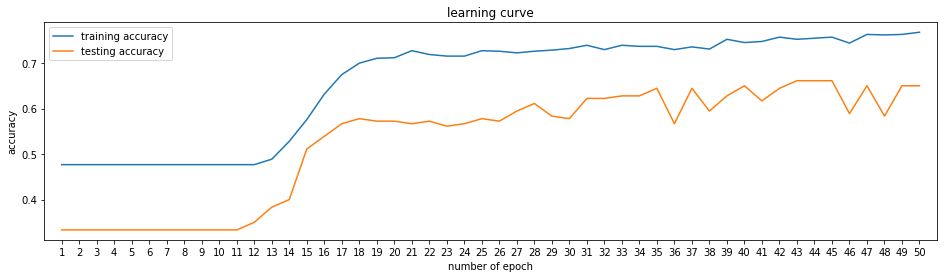

In [14]:
plt.figure(figsize=(16,4))
plt.plot(list(range(num_epochs)), train_acc, label='training accuracy')
plt.plot(list(range(num_epochs)), test_acc, label='testing accuracy')
plt.legend()
plt.xlabel('number of epoch')
plt.ylabel('accuracy')
plt.xlim(-1, num_epochs)
plt.xticks(list(range(num_epochs)), list(range(1, num_epochs+1)))
plt.title('learning curve')
plt.show()

In [15]:
seed = 1
device = 'cuda'
optimizer_name = 'Adam'
#scheduler_name = 'MultiStepLR'
num_epochs = 60
lr = 0.0005
device = torch.device(device)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
in_channels = 3
out_channels = 3
model = LeNet5(in_channels, out_channels).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = make_optimizer(optimizer_name, model, lr=lr, momentum=0, weight_decay=0)
#scheduler = make_scheduler(scheduler_name, optimizer, milestones=[5], factor=0.1)

train_acc = []
test_acc = []
for epoch in range(1, num_epochs + 1):
    a = train(model, device, train_loader, criterion, optimizer, epoch)
    b = test(model, device, test_loader, criterion, epoch)
    train_acc.append(a)
    test_acc.append(b)
    
    if epoch == 1 or b > last: # save the best model
        torch.save(model.state_dict(), 'lenet.pth')
        last = b
    
    #scheduler.step()
    print('Optimizer Learning rate: {0:.4f}'.format(optimizer.param_groups[0]['lr']))

Train(1)[0%]: Loss: 1.0856
Train(1)[48%]: Loss: 1.0042
Train(1)[96%]: Loss: 0.8807
Test(1): Loss: 1.0074, Accuracy: 56.1111%
Optimizer Learning rate: 0.0005
Train(2)[0%]: Loss: 0.6258
Train(2)[48%]: Loss: 0.6539
Train(2)[96%]: Loss: 0.6307
Test(2): Loss: 0.8539, Accuracy: 61.1111%
Optimizer Learning rate: 0.0005
Train(3)[0%]: Loss: 0.6154
Train(3)[48%]: Loss: 0.5978
Train(3)[96%]: Loss: 0.5837
Test(3): Loss: 0.8573, Accuracy: 63.8889%
Optimizer Learning rate: 0.0005
Train(4)[0%]: Loss: 0.5460
Train(4)[48%]: Loss: 0.5558
Train(4)[96%]: Loss: 0.5413
Test(4): Loss: 0.8067, Accuracy: 65.5556%
Optimizer Learning rate: 0.0005
Train(5)[0%]: Loss: 0.4044
Train(5)[48%]: Loss: 0.4805
Train(5)[96%]: Loss: 0.4945
Test(5): Loss: 0.7580, Accuracy: 72.2222%
Optimizer Learning rate: 0.0005
Train(6)[0%]: Loss: 0.5422
Train(6)[48%]: Loss: 0.4851
Train(6)[96%]: Loss: 0.4753
Test(6): Loss: 0.7240, Accuracy: 75.5556%
Optimizer Learning rate: 0.0005
Train(7)[0%]: Loss: 0.5119
Train(7)[48%]: Loss: 0.4364
Tra

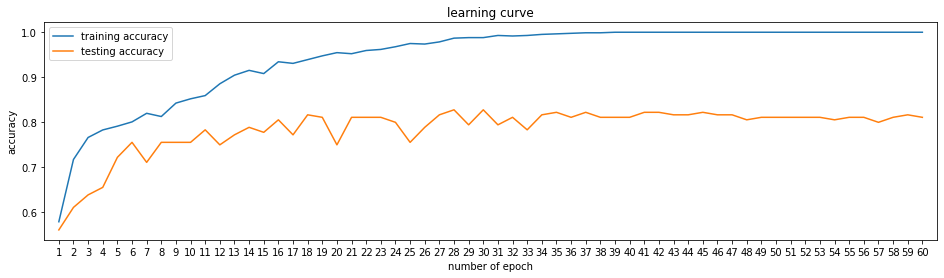

In [17]:
plt.figure(figsize=(16,4))
plt.plot(list(range(num_epochs)), train_acc, label='training accuracy')
plt.plot(list(range(num_epochs)), test_acc, label='testing accuracy')
plt.legend()
plt.xlabel('number of epoch')
plt.ylabel('accuracy')
plt.xlim(-1, num_epochs)
plt.xticks(list(range(num_epochs)), list(range(1, num_epochs+1)))
plt.title('learning curve')
plt.show()